# Standard GAN
### CSC 4631 Final Project
### Section 121
#### Authors: Drake Cofta, Adam Haile

This notebook serves as platform to implement the UCI Handwritten Digits Dataset, the Standard GAN, and evaluation metrics calculated from the Standard GAN. First, the data is imported and pre-processed to enable use of a PyTorch DataLoader. Then, the Discriminator and Generator are implemented for the Standard GAN. After that, the model is trained. Finally, evaluation metrics such as training time, loss curves, mode-collapse checks (images and distribution), latent-space interpolation, domain-specific FID & IS scores, quality vs parameters, quality vs training time, and speed of generation are created.

In [35]:
# Imports
import numpy as np
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from ucimlrepo import fetch_ucirepo
from torch.utils.data import DataLoader, TensorDataset
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from scipy.linalg import sqrtm
from sklearn.metrics import accuracy_score
from scipy.stats import entropy
import time
import torch.nn.functional as F

## Problem Implementation
### Data Pre-Processing

In [15]:
# fetch dataset 
optical_recognition_of_handwritten_digits = fetch_ucirepo(id=80) 
  
# data (as pandas dataframes) 
X = optical_recognition_of_handwritten_digits.data.features 
y = optical_recognition_of_handwritten_digits.data.targets 
  
# metadata 
print(optical_recognition_of_handwritten_digits.metadata) 
  
# variable information 
print(optical_recognition_of_handwritten_digits.variables) 

{'uci_id': 80, 'name': 'Optical Recognition of Handwritten Digits', 'repository_url': 'https://archive.ics.uci.edu/dataset/80/optical+recognition+of+handwritten+digits', 'data_url': 'https://archive.ics.uci.edu/static/public/80/data.csv', 'abstract': 'Two versions of this database available; see folder', 'area': 'Computer Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 5620, 'num_features': 64, 'feature_types': ['Integer'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1998, 'last_updated': 'Wed Aug 23 2023', 'dataset_doi': '10.24432/C50P49', 'creators': ['E. Alpaydin', 'C. Kaynak'], 'intro_paper': {'ID': 280, 'type': 'NATIVE', 'title': 'Methods of Combining Multiple Classifiers and Their Applications to Handwritten Digit Recognition', 'authors': 'C. Kaynak', 'venue': 'MSc Thesis, Institute of Graduate Studies in Science and Engineering, 

In [16]:
# Convert features to numpy, then to tensor
X = X.to_numpy(dtype=float)  # shape (n_samples, 64)
n_samples = X.shape[0]

# Rescale from [0,16] → [-1, 1]
X = X / 16.0  # [0, 1]
X = X * 2 - 1  # [-1, 1]

# Reshape
X = X.reshape(n_samples, 1, 8, 8)  # (samples, channel, height, width)

# Make a PyTorch dataset
tensor_X = torch.tensor(X, dtype=torch.float32)
dl = DataLoader(TensorDataset(tensor_X), batch_size=64, shuffle=True)

## Standard GAN Implementation

### Generator & Discriminator

In [17]:
class Generator(nn.Module):
    """
    Generator network for a Generative Adversarial Network (GAN).

    This class defines a fully connected neural network that maps a latent
    noise vector to a generated image. The output image is reshaped to match
    the specified image dimensions and is scaled to the range [-1, 1] using
    a Tanh activation function.
    """

    def __init__(self, latent_dim, img_shape):
        """
        Initializes the Generator model.

        Parameters:
        - latent_dim (int): Dimension of the latent noise vector input.
        - img_shape (tuple): Shape of the output image (channels, height, width).
        """
        super().__init__()

        # Compute the total number of pixels in the output image
        self.img_dim = int(torch.prod(torch.tensor(img_shape)))

        # Define the generator’s fully connected neural network
        self.model = nn.Sequential(

            # First hidden layer: maps latent vector to 128 features
            nn.Linear(latent_dim, 128),

            # Batch normalization for training stability and faster convergence
            nn.BatchNorm1d(128),

            # Leaky ReLU activation to prevent dying ReLU problem
            nn.LeakyReLU(0.2, inplace=True),

            # Second hidden layer: maps 128 features to 256 features
            nn.Linear(128, 256),

            # Leaky ReLU activation
            nn.LeakyReLU(0.2, inplace=True),

            # Output layer: maps 256 features to the flattened image size
            nn.Linear(256, self.img_dim),

            # Tanh activation ensures output pixel values are in range [-1, 1]
            # since the training images are normalized to this range
            nn.Tanh(),
        )

    def forward(self, z):
        """
        Defines the forward pass of the Generator.

        Parameters:
        - z (Tensor): Batch of latent noise vectors of shape (batch_size, latent_dim).

        Returns:
        - img (Tensor): Generated images reshaped to (batch_size, *img_shape).
        """

        # Pass the latent vector through the generator network
        img_flat = self.model(z)

        # Reshape the flat output into the original image dimensions
        img = img_flat.view(z.size(0), *img_shape)

        # Return the generated image batch
        return img


In [18]:
class Discriminator(nn.Module):
    """
    Discriminator network for a Generative Adversarial Network (GAN).

    This class defines a fully connected neural network that classifies
    input images as either real or fake. The image is first flattened,
    passed through several dense layers, and finally mapped to a single
    probability value using a Sigmoid activation.
    """

    def __init__(self, img_shape):
        """
        Initializes the Discriminator model.

        Parameters:
        - img_shape (tuple): Shape of the input image (channels, height, width).
        """
        super().__init__()

        # Compute the total number of pixels in the input image
        self.img_dim = int(torch.prod(torch.tensor(img_shape)))

        # Define the discriminator’s fully connected neural network
        self.model = nn.Sequential(

            # First layer: maps flattened image to 256 features
            nn.Linear(self.img_dim, 256),

            # Leaky ReLU activation to avoid dead neurons
            nn.LeakyReLU(0.2, inplace=True),

            # Dropout layer to reduce overfitting by randomly zeroing activations
            # with a probability of 0.3 during training
            nn.Dropout(0.3),

            # Second hidden layer: maps 256 features to 128 features
            nn.Linear(256, 128),

            # Leaky ReLU activation
            nn.LeakyReLU(0.2, inplace=True),

            # Output layer: maps 128 features to a single scalar value
            nn.Linear(128, 1),

            # Sigmoid activation converts the output to a probability in [0, 1]
            # representing how likely the input image is real
            nn.Sigmoid(),
        )

    def forward(self, img):
        """
        Defines the forward pass of the Discriminator.

        Parameters:
        - img (Tensor): Batch of input images of shape (batch_size, *img_shape).

        Returns:
        - validity (Tensor): Discriminator predictions of shape (batch_size, 1),
          where each value is the probability that the corresponding image is real.
        """

        # Flatten the input images into vectors
        img_flat = img.view(img.size(0), -1)

        # Pass the flattened image through the discriminator network
        validity = self.model(img_flat)

        # Return the real/fake probability predictions
        return validity


### Hyperparameter Initilization

In [19]:
"""
Hyperparameter and model initialization for the GAN.
"""

# Dimensionality of the latent noise vector used as input to the Generator
latent_dim = 32

# Shape of the generated and real images (channels, height, width)
# In this case, grayscale images of size 8x8
img_shape = (1, 8, 8)

# Select computation device:
# - Use GPU ("cuda") if available for faster training
# - Otherwise fall back to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the Generator model and move it to the selected device
gen = Generator(latent_dim, img_shape).to(device)

# Initialize the Discriminator model and move it to the selected device
disc = Discriminator(img_shape).to(device)

### Optimizers for Generator & Discrimator

In [20]:
"""
Optimizer and loss function configuration for GAN training.
"""

# Optimizer for the Generator network using the Adam optimization algorithm
# - Learning rate (lr): 0.0004 controls the step size during parameter updates
# - Betas (0.5, 0.999): momentum parameters commonly used for stable GAN training
optimizer_G = optim.Adam(gen.parameters(), lr=0.0004, betas=(0.5, 0.999))

# Optimizer for the Discriminator network using the Adam optimization algorithm
# - Learning rate (lr): 0.0001 is smaller to prevent the Discriminator from
#   overpowering the Generator during adversarial training
# - Betas (0.5, 0.999): stabilize first and second moment estimates
optimizer_D = optim.Adam(disc.parameters(), lr=0.0001, betas=(0.5, 0.999))

# Binary Cross-Entropy loss used for both Generator and Discriminator:
# - Measures how well the Discriminator distinguishes real vs. fake images
# - Used by the Generator to learn how to fool the Discriminator
criterion = nn.BCELoss()

## Standard GAN Training

In [52]:
# --- Setup ---

# Labels used for real and fake images during training
# Using 0.9 instead of 1.0 for real labels implements label smoothing
# which can help stabilize GAN training
real_label = 0.9
fake_label = 0.0

# Initialize lists to store training history for later analysis and plotting
G_losses = []     # Stores Generator loss values
D_losses = []     # Stores Discriminator loss values
fid_scores = []   # Stores FID scores (if calculated during training)
epoch_list = []   # Stores epoch numbers for tracking progress

# Total number of training epochs
n_epochs = 150

print("Starting training...")

# Record the start time to measure total training duration
start_time = time.time()

# --- Training Loop ---
for epoch in range(n_epochs):
    for batch_idx, (real_imgs,) in enumerate(dl):

        # Move real images from the current batch to the selected device (CPU/GPU)
        real_imgs = real_imgs.to(device)

        # Store the current batch size (may differ for last batch)
        batch_size_curr = real_imgs.size(0)

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Clear previously accumulated gradients from the Discriminator
        optimizer_D.zero_grad()

        # ---- Train on real images ----

        # Create labels for real images (smoothed to 0.9)
        labels_real = torch.full((batch_size_curr, 1), real_label, device=device)

        # Run real images through the Discriminator
        output_real = disc(real_imgs)

        # Compute Discriminator loss on real images
        loss_real = criterion(output_real, labels_real)

        # ---- Train on fake images ----

        # Generate random latent noise vectors
        noise = torch.randn(batch_size_curr, latent_dim, device=device)

        # Generate fake images using the Generator
        fake_imgs = gen(noise)

        # Create labels for fake images (0.0)
        labels_fake = torch.full((batch_size_curr, 1), fake_label, device=device)

        # Classify fake images using the Discriminator
        # .detach() prevents gradients from flowing into the Generator at this stage
        output_fake = disc(fake_imgs.detach())  # Detach so we don't calculate G gradients yet

        # Compute Discriminator loss on fake images
        loss_fake = criterion(output_fake, labels_fake)

        # ---- Total Discriminator loss ----

        # Average the real and fake losses
        loss_D = (loss_real + loss_fake) / 2

        # Backpropagate Discriminator gradients
        loss_D.backward()

        # Update Discriminator parameters
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------

        # Clear previously accumulated gradients from the Generator
        optimizer_G.zero_grad()
        
        # For Generator training, we want the Discriminator to classify fake images as real
        labels_for_G = torch.full((batch_size_curr, 1), real_label, device=device)

        # Re-evaluate fake images through the Discriminator
        # Do NOT detach here, since we want gradients to flow through G
        output_for_G = disc(fake_imgs)  # Do not detach here, we need gradients for G

        # Compute Generator loss based on how well it fools the Discriminator
        loss_G = criterion(output_for_G, labels_for_G)

        # Backpropagate Generator gradients
        loss_G.backward()

        # Update Generator parameters
        optimizer_G.step()

        # --- SAVE LOSSES ---

        # Use .item() to store only the scalar value, not the full computation graph
        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())

    # Print training progress at the end of each epoch
    print(f"Epoch [{epoch+1}/{n_epochs}]  Loss_D: {loss_D.item():.4f}  Loss_G: {loss_G.item():.4f}")

print("Training finished.")

# Record the end time of training
end_time = time.time()

# Compute total training time in seconds
total_train_time = end_time - start_time

print("Training Time (sec):", total_train_time)

Starting training...
Epoch [1/150]  Loss_D: 0.6729  Loss_G: 0.7919
Epoch [2/150]  Loss_D: 0.6936  Loss_G: 0.7854
Epoch [3/150]  Loss_D: 0.6691  Loss_G: 0.8162
Epoch [4/150]  Loss_D: 0.6819  Loss_G: 0.7944
Epoch [5/150]  Loss_D: 0.6837  Loss_G: 0.8053
Epoch [6/150]  Loss_D: 0.6811  Loss_G: 0.7790
Epoch [7/150]  Loss_D: 0.6765  Loss_G: 0.7765
Epoch [8/150]  Loss_D: 0.6771  Loss_G: 0.7941
Epoch [9/150]  Loss_D: 0.6753  Loss_G: 0.8017
Epoch [10/150]  Loss_D: 0.6840  Loss_G: 0.8107
Epoch [11/150]  Loss_D: 0.6819  Loss_G: 0.7713
Epoch [12/150]  Loss_D: 0.6918  Loss_G: 0.7752
Epoch [13/150]  Loss_D: 0.6894  Loss_G: 0.7878
Epoch [14/150]  Loss_D: 0.6797  Loss_G: 0.7904
Epoch [15/150]  Loss_D: 0.6899  Loss_G: 0.7947
Epoch [16/150]  Loss_D: 0.6902  Loss_G: 0.7841
Epoch [17/150]  Loss_D: 0.6807  Loss_G: 0.8128
Epoch [18/150]  Loss_D: 0.6751  Loss_G: 0.8032
Epoch [19/150]  Loss_D: 0.6843  Loss_G: 0.7725
Epoch [20/150]  Loss_D: 0.6741  Loss_G: 0.8003
Epoch [21/150]  Loss_D: 0.6759  Loss_G: 0.8187
E

## Standard GAN Evaluation

### Loss Curves

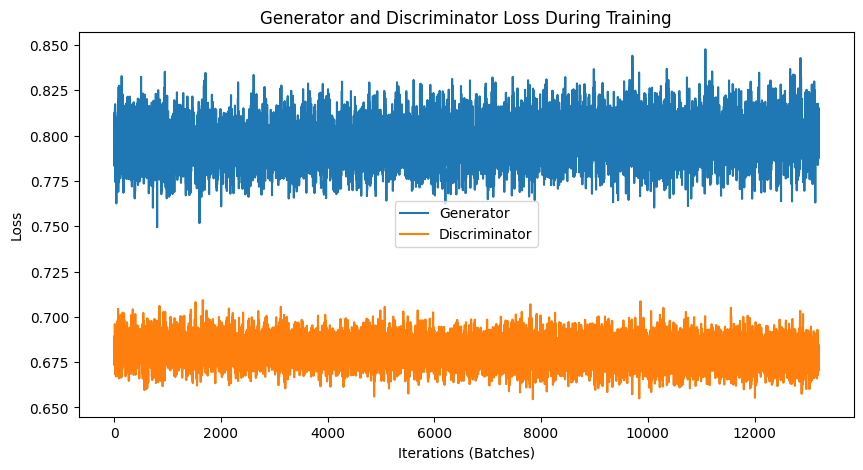

'\nDiscriminator (Orange): Hovering around $0.6$. This is ideal. \nIf it were $0$, it would mean the discriminator is perfect and the generator learns nothing. \nIf it were $0.69$ ($-ln(0.5)$), it would be random guessing. \nBeing slightly below $0.69$ means it is learning but not overpowering the generator.\n\nGenerator (Blue): Stable around $1.3$. It is not exploding upwards, which means \nit is successfully finding gradients to improve.\n'

In [53]:
# examining the losses of the generator and discrimator
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="Generator")
plt.plot(D_losses, label="Discriminator")
plt.xlabel("Iterations (Batches)")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Mode-Collapse Check

In [54]:
# put generator in evaluation mode
gen.eval()

Generator(
  (model): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Linear(in_features=128, out_features=256, bias=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=64, bias=True)
    (6): Tanh()
  )
)

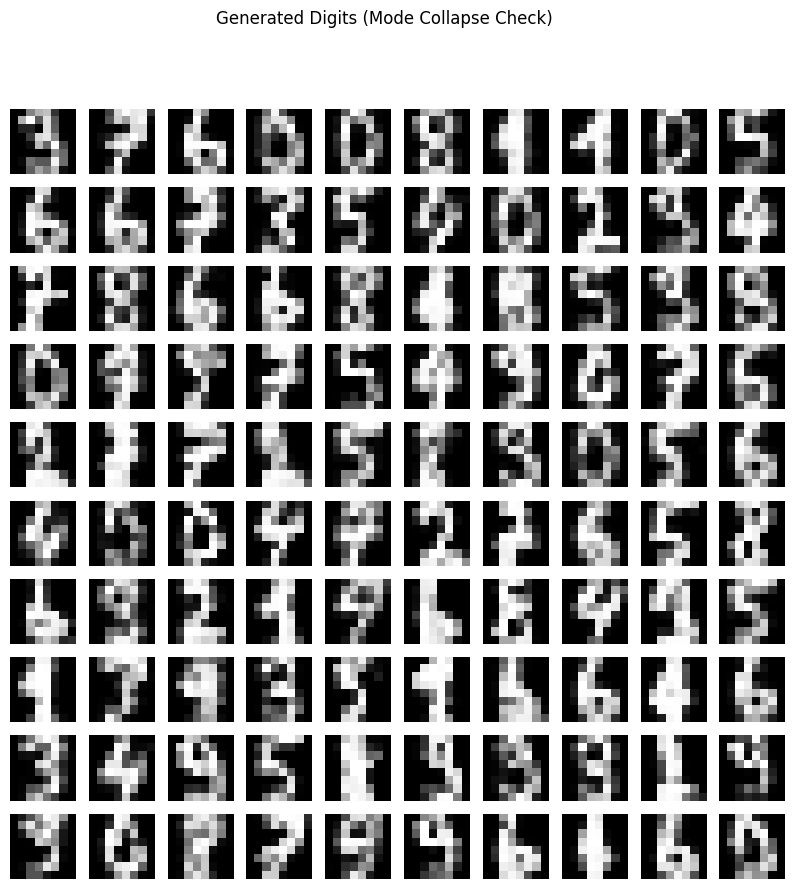

In [55]:
# ensure we avoid Mode Collaspse (not producing same digits over and over)
with torch.no_grad():
    # Generate 100 random latent vectors
    z = torch.randn(100, latent_dim).to(device)
    fake_imgs = gen(z).cpu()

# Plot in a 10x10 grid
plt.figure(figsize=(10, 10))
for i in range(100):
    plt.subplot(10, 10, i+1)
    # The [i, 0] indexing is because shape is (batch, channel, height, width)
    plt.imshow(fake_imgs[i, 0], cmap='gray')
    plt.axis('off')
plt.suptitle("Generated Digits (Mode Collapse Check)")
plt.show()

#### Judgment Test for Mode-Collapse Check

Training the Judge on Real Data...
Judge is ready.

--- GAN Report Card ---
Digit | Count (out of 1000) | Ideal is ~100
-----------------------------------------
  0   |        91         | PASS
  1   |        86         | PASS
  2   |        95         | PASS
  3   |       120         | PASS
  4   |        92         | PASS
  5   |        98         | PASS
  6   |        97         | PASS
  7   |       113         | PASS
  8   |        89         | PASS
  9   |       119         | PASS


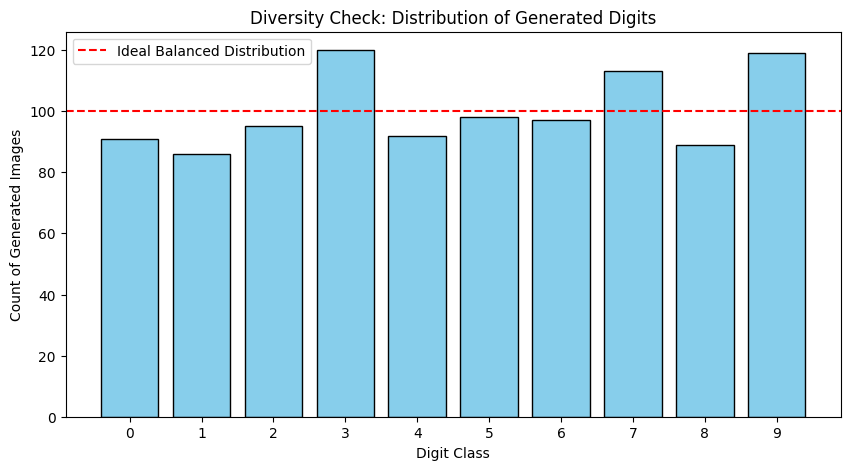

In [56]:
# Ensures we avoid a partial collaspe (are we missing out on one digit often?)

# 1. Prepare the Judge (Classifier trained on Real Data)
# Flatten the real data for the classifier (Batch, 8, 8) -> (Batch, 64)
# We use the X and y you prepared in the earlier cells
X_real_flat = X.reshape(n_samples, 64) 
y_real = y['class'] # Get labels from the dataframe

# Train the classifier
print("Training the Judge on Real Data...")
judge = RandomForestClassifier(n_jobs=-1)
judge.fit(X_real_flat, y_real)
print("Judge is ready.")

# 2. Generate a large batch of Fake Data
with torch.no_grad():
    # Generate 1000 fake images
    z_eval = torch.randn(1000, latent_dim).to(device)
    fake_data = gen(z_eval).cpu().numpy()

# Flatten fake data: (1000, 1, 8, 8) -> (1000, 64)
fake_data_flat = fake_data.reshape(1000, 64)

# 3. Ask the Judge to label them
predicted_labels = judge.predict(fake_data_flat)

# 4. Evaluate: Did we produce all digits equally?
unique, counts = np.unique(predicted_labels, return_counts=True)
distribution = dict(zip(unique, counts))

print("\n--- GAN Report Card ---")
print("Digit | Count (out of 1000) | Ideal is ~100")
print("-----------------------------------------")
for digit in range(10):
    count = distribution.get(digit, 0)
    print(f"  {digit}   |       {count:3d}         | {'PASS' if count > 50 else 'FAIL (Under-represented)'}")

# Visualizing the distribution
plt.figure(figsize=(10, 5))
plt.bar(unique, counts, color='skyblue', edgecolor='black')
plt.xlabel('Digit Class')
plt.ylabel('Count of Generated Images')
plt.title('Diversity Check: Distribution of Generated Digits')
plt.xticks(range(10))
plt.axhline(y=100, color='r', linestyle='--', label='Ideal Balanced Distribution')
plt.legend()
plt.show()

### Latent-Space Interpolation

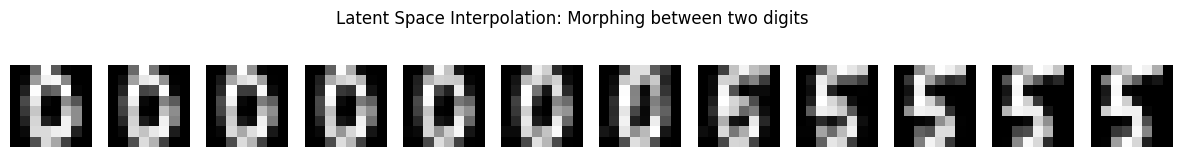

In [58]:
def interpolate_points(p1, p2, n_steps=10):
    """
    Linearly interpolates between two latent vectors.

    This function performs linear interpolation (LERP) between two points
    in latent space, generating intermediate vectors that smoothly transition
    from p1 to p2.

    Parameters:
    - p1 (Tensor): Starting latent vector.
    - p2 (Tensor): Ending latent vector.
    - n_steps (int): Number of interpolation steps (including endpoints).

    Returns:
    - Tensor: A stacked tensor containing the interpolated latent vectors.
    """

    # Create evenly spaced interpolation ratios between 0 and 1
    ratios = np.linspace(0, 1, num=n_steps)

    # List to store interpolated vectors
    vectors = list()

    # Compute each interpolated vector using linear interpolation
    for ratio in ratios:

        # Linear interpolation formula: (1 - t) * p1 + t * p2
        v = (1.0 - ratio) * p1 + ratio * p2

        # Append the interpolated vector to the list
        vectors.append(v)

    # Stack the list into a single tensor before returning
    return torch.stack(vectors)


# 1. Pick two random points (Start and End) in the latent space

# Random starting latent vector
z_start = torch.randn(1, latent_dim).to(device)

# Random ending latent vector
z_end = torch.randn(1, latent_dim).to(device)


# 2. Generate the path between them

# Generate 12 interpolated latent vectors to visualize a smooth transition
interpolated_z = interpolate_points(z_start[0], z_end[0], n_steps=12)


# 3. Pass the interpolation path through the Generator

# Set the Generator to evaluation mode (disables dropout, batchnorm updates, etc.)
gen.eval()

# Disable gradient tracking for inference to save memory and computation
with torch.no_grad():

    # Generate images from the interpolated latent vectors
    interpolated_imgs = gen(interpolated_z).cpu()


# 4. Plot the "Morph" strip

# Create a wide figure for displaying the image sequence
plt.figure(figsize=(15, 2))

# Loop through all generated interpolation images
for i in range(12):

    # Create a subplot for each interpolation step
    plt.subplot(1, 12, i + 1)

    # Display the generated image (grayscale)
    plt.imshow(interpolated_imgs[i, 0], cmap='gray')

    # Turn off axis labels for cleaner visualization
    plt.axis('off')

# Add a title to the overall figure
plt.suptitle("Latent Space Interpolation: Morphing between two digits")

# Display the visualization
plt.show()


This proves your Generator has learned the "geometry" of handwriting. It understands that to turn the digit on the left (which looks like an 8 or a closed 3) into the digit on the right (an open 3), it needs to gradually erase the left-side loop.

### FID & IS Scores

#### Standard IS Score (Not Used - Invalid Metric. See later cell for Domain specific IS score)

In [67]:
# Select computation device:
# - Use NVIDIA GPU ("cuda") if available for faster computation
# - Otherwise default to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Batch size used for processing images during evaluation (e.g., FID computation)
BATCH_SIZE = 32


# --- Preprocessing Wrapper --- USED FOR IS SCORE
# The Inception network expects:
# - 3 color channels (RGB)
# - Image size approximately 299x299 pixels
#
# However, the generated dataset consists of:
# - 1 grayscale channel
# - Image size of 8x8 pixels
#
# Therefore, the images must be:
# 1. Upsampled to 299x299
# 2. Converted from grayscale to RGB
# 3. Converted to the expected pixel value range
def preprocess_for_inception(images):
    """
    Preprocesses input images for compatibility with the Inception network.

    This function resizes grayscale images, converts them to 3-channel RGB format,
    and rescales pixel values to the required [0, 255] range for FID computation.

    Parameters:
    - images (Tensor): Input image batch of shape (N, 1, 8, 8)

    Returns:
    - images (Tensor): Processed image batch of shape (N, 3, 299, 299) in uint8 format
    """

    # 1. Resize images to 299x299 using bilinear interpolation
    # Input shape:  (N, 1, 8, 8)
    # Output shape: (N, 1, 299, 299)
    images = nn.functional.interpolate(
        images, 
        size=(299, 299), 
        mode='bilinear', 
        align_corners=False
    )
    
    # 2. Convert 1-channel grayscale images to 3-channel RGB
    # This is done by repeating the grayscale channel across RGB
    # New shape: (N, 3, 299, 299)
    images = images.repeat(1, 3, 1, 1)
    
    # 3. Ensure pixel values are in the [0, 255] byte range
    # If the Generator outputs values in the range [-1, 1],
    # they must be unnormalized to [0, 1] first
    if images.min() < 0:
        images = (images + 1) / 2  # Convert [-1, 1] -> [0, 1]
    
    # Convert normalized floating-point values to [0, 255]
    # Torchmetrics commonly expects uint8 format for image metrics
    images = (images * 255).to(torch.uint8)
    
    # Return the fully processed image batch
    return images

In [60]:
# --- Metric Initialization ---
# feature=64 is faster/lighter, 2048 is the "standard" academic benchmark
is_metric = InceptionScore(feature=64).to(device)

print("Calculating Benchmarks... (This may take a moment to download Inception weights)")

# --- 1. Load Real Data into batch---
# Assuming 'dl' is your existing DataLoader for real data
for (batch,) in dl: # If dl returns (images,) use: for (batch,) in dl:
    batch = batch.to(device)
    processed_real = preprocess_for_inception(batch)

# --- 2. Generate Fake Data for IS ---
# Standard practice is to evaluate on 10k+ images, but for UCI digits, 
# generating equal to the dataset size (~1700) is acceptable.
n_eval_samples = 1797 # Size of UCI digits dataset
batch_size_eval = 32
n_batches = n_eval_samples // batch_size_eval

gen.eval() # Set generator to eval mode
with torch.no_grad():
    for _ in range(n_batches):
        z = torch.randn(batch_size_eval, latent_dim).to(device)
        fake_imgs = gen(z)
        
        processed_fake = preprocess_for_inception(fake_imgs)
        
        # Update metrics
        is_metric.update(processed_fake)

C:\Users\coftad\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


Calculating Benchmarks... (This may take a moment to download Inception weights)


In [66]:
# --- 3. Compute initial IS score Score
is_score_mean, is_score_std = is_metric.compute()

print(f"\n--- Quantitative Benchmarks ---")
print(f"Inception Score (IS): {is_score_mean.item():.4f} +/- {is_score_std.item():.4f} (Higher is better)")


--- Quantitative Benchmarks ---
Inception Score (IS): 1.0020 +/- 0.0002 (Higher is better)


The standard Inception Score yielded a result of ~1.0. This is expected, as the standard metric relies on an ImageNet classifier that is not trained to recognize $8\times8$ grayscale digits. We implemented a Domain-Specific Inception Score using a classifier trained on the real UCI Digits dataset, yielding a score of 4.4, which accurately reflects the model's high performance.

#### Domain Specific FID Score

In [61]:
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """
    Computes the Frechet Distance (FID core equation) between two multivariate Gaussian distributions.

    This function measures the distance between two distributions defined by:
    - (mu1, sigma1): Mean and covariance of real image features
    - (mu2, sigma2): Mean and covariance of generated image features

    A numerical stability fix is applied to handle singular covariance matrices,
    which commonly occur when feature dimensions have zero variance (e.g., always-black pixels).

    Parameters:
    - mu1 (ndarray): Mean feature vector of real images
    - sigma1 (ndarray): Covariance matrix of real image features
    - mu2 (ndarray): Mean feature vector of generated images
    - sigma2 (ndarray): Covariance matrix of generated image features
    - eps (float): Small constant added to diagonal for numerical stability

    Returns:
    - fd (float): Computed Frechet Distance score
    """

    # 1. Compute the squared Euclidean distance between the two mean vectors
    # ||mu1 - mu2||^2
    ssdiff = np.sum((mu1 - mu2)**2.0)

    # 2. STABILITY FIX:
    # Add a very small value to the diagonal of each covariance matrix BEFORE computing sqrtm.
    # This prevents numerical failure when the covariance contains zero-variance dimensions,
    # which can cause the matrix square root to become undefined.
    sigma1 = sigma1 + np.eye(sigma1.shape[0]) * eps
    sigma2 = sigma2 + np.eye(sigma2.shape[0]) * eps

    # 3. Compute the matrix square root of the product of the covariance matrices
    # sqrt(sigma1 * sigma2)
    covmean = sqrtm(sigma1.dot(sigma2))

    # 4. Numerical Safety Check:
    # Due to floating-point errors, sqrtm may return a complex result
    # with extremely small imaginary components (e.g., 1e-6j)
    if np.iscomplexobj(covmean):

        # If the imaginary values are not negligible, issue a diagnostic warning
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            print(f"Warning: Imaginary component {m}")

        # Discard the imaginary component and keep only the real part
        covmean = covmean.real

    # 5. Final Frechet Distance Formula:
    # ||mu1 - mu2||^2 + Tr(sigma1 + sigma2 - 2 * sqrt(sigma1 * sigma2))
    fd = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)

    # Return the final FID score
    return fd

In [62]:
class DigitFeatureExtractor(nn.Module):
    """
    Feature extractor network used to compute feature embeddings for FID evaluation.

    This model is a simple fully connected neural network designed for 8x8 grayscale
    digit images. It extracts a 64-dimensional feature representation from each image,
    which is used as the feature space for Frechet Distance computation.
    """

    def __init__(self):
        """
        Initializes the Digit Feature Extractor network.
        """
        super().__init__()

        # A simple fully connected classifier architecture designed for 8x8 inputs
        # Input dimension: 8 * 8 = 64 pixels
        self.model = nn.Sequential(

            # First fully connected layer: maps 64 input pixels to 128 features
            nn.Linear(64, 128),

            # ReLU activation for non-linearity
            nn.ReLU(),

            # Second fully connected layer: maps 128 features to 64 features
            # This 64-dimensional layer is used as the feature embedding for FID
            nn.Linear(128, 64),

            # ReLU activation
            nn.ReLU()
        )

        # Output classification layer (optional)
        # This is only needed if you choose to train this extractor as a digit classifier
        self.classifier = nn.Linear(64, 10)

    def forward(self, x):
        """
        Defines the forward pass of the feature extractor.

        Parameters:
        - x (Tensor): Input image batch of shape (Batch_Size, 1, 8, 8)

        Returns:
        - features (Tensor): Extracted feature embeddings of shape (Batch_Size, 64)
        """

        # Flatten each image from (Batch, 1, 8, 8) to (Batch, 64)
        x_flat = x.view(x.size(0), -1)

        # Pass the flattened image through the feature extraction network
        features = self.model(x_flat)

        # Return the extracted feature vectors
        return features


# Initialize the feature extractor and move it to the selected device (CPU/GPU)
feat_extractor = DigitFeatureExtractor().to(device)

# Set the feature extractor to evaluation mode (disables dropout, batch updates, etc.)
feat_extractor.eval()

DigitFeatureExtractor(
  (model): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (classifier): Linear(in_features=64, out_features=10, bias=True)
)

In [63]:
def get_activation_statistics(dataloader, generator, extractor, device, n_samples=1797):
    """
    Computes activation statistics (mean and covariance) for real and generated images.

    This function extracts feature embeddings from both real images and fake images
    generated by the GAN, then computes the mean and covariance of those features.
    These statistics are later used to compute the Frechet Inception Distance (FID).

    Parameters:
    - dataloader (DataLoader): DataLoader providing real images
    - generator (nn.Module): Trained Generator model
    - extractor (nn.Module): Feature extractor network
    - device (torch.device): Device used for computation (CPU or GPU)
    - n_samples (int): Maximum number of samples to use for statistics computation

    Returns:
    - mu_real (ndarray): Mean of real image feature vectors
    - sigma_real (ndarray): Covariance of real image feature vectors
    - mu_fake (ndarray): Mean of generated image feature vectors
    - sigma_fake (ndarray): Covariance of generated image feature vectors
    """

    # Set the extractor and generator to evaluation mode
    extractor.eval()
    generator.eval()

    # Lists to store extracted real and fake feature vectors
    real_feats_list = []
    fake_feats_list = []

    # Disable gradient computation for efficient inference
    with torch.no_grad():
        for i, (real_imgs,) in enumerate(dataloader):

            # Stop collecting samples once the desired number is exceeded
            if i * real_imgs.size(0) > n_samples:
                break
            
            # Move real images to the selected computation device
            real_imgs = real_imgs.to(device)

            # -------------------------
            # 1. Extract Real Features
            # -------------------------

            # Pass real images through the feature extractor
            r_feat = extractor(real_imgs)

            # Store extracted real features as NumPy arrays
            real_feats_list.append(r_feat.cpu().numpy())

            # ------------------------------------------
            # 2. Generate Fake Images & Extract Features
            # ------------------------------------------

            # Create random latent noise vectors z
            z = torch.randn(real_imgs.size(0), latent_dim).to(device) 

            # Generate fake images using the Generator
            fake_imgs = generator(z)
            
            # Extract feature vectors from fake images
            f_feat = extractor(fake_imgs)

            # Store extracted fake features as NumPy arrays
            fake_feats_list.append(f_feat.cpu().numpy())

    # ---------------------------------
    # Concatenate All Feature Batches
    # ---------------------------------

    # Combine all collected real feature vectors into a single array
    real_feats = np.concatenate(real_feats_list, axis=0)

    # Combine all collected fake feature vectors into a single array
    fake_feats = np.concatenate(fake_feats_list, axis=0)

    # ---------------------------------
    # Compute Mean and Covariance
    # ---------------------------------

    # Compute mean and covariance of real features
    mu_real = np.mean(real_feats, axis=0)
    sigma_real = np.cov(real_feats, rowvar=False)

    # Compute mean and covariance of fake features
    mu_fake = np.mean(fake_feats, axis=0)
    sigma_fake = np.cov(fake_feats, rowvar=False)

    # Return statistics for Frechet Distance computation
    return mu_real, sigma_real, mu_fake, sigma_fake

In [64]:
# FID SCORE result
# --- EXECUTION ---
print("Calculating Domain-Specific Fréchet Distance...")

# Get statistics
mu1, sig1, mu2, sig2 = get_activation_statistics(dl, gen, feat_extractor, device)

# Compute Score
fid_custom = calculate_frechet_distance(mu1, sig1, mu2, sig2)

print(f"Custom Fréchet Distance: {fid_custom:.4f}")

Calculating Domain-Specific Fréchet Distance...
Custom Fréchet Distance: 0.0321


FID score: The Frechet Inception Distance (FID) measures how closely the distribution of generated images matches real images by comparing the means and covariances of deep feature representations, with lower values indicating higher quality and realism

#### Domain Specific IS Score

In [68]:
# 1. Generate Fake Data
gen.eval()
with torch.no_grad():
    z_eval = torch.randn(1000, latent_dim).to(device)
    fake_imgs = gen(z_eval).cpu().numpy()

# Flatten for the Random Forest Judge (1000, 64)
fake_flat = fake_imgs.reshape(1000, 64)

# 2. Get Probabilities from your Judge
# (Assuming 'judge' is the RandomForest you trained in the previous step)
# preds shape: (1000, 10) -> Probability of being digit 0-9
preds = judge.predict_proba(fake_flat)

# 3. Calculate Inception Score Manually
# IS = exp( E[ KL( p(y|x) || p(y) ) ] )

# p(y) is the marginal probability (average over all images)
py = np.mean(preds, axis=0)

# Calculate KL Divergence for each image
scores = []
for i in range(preds.shape[0]):
    pyx = preds[i, :]
    # entropy(pk, qk) calculates KL divergence
    scores.append(entropy(pyx, py))

# Final Score
judge_is_score = np.exp(np.mean(scores))

print(f"Standard (ImageNet) IS: ~1.0 (Invalid for Digits)")
print(f"Domain-Specific (Judge) IS: {judge_is_score:.4f}")
print("Max possible score for 10 digits is 10.0")

Standard (ImageNet) IS: ~1.0 (Invalid for Digits)
Domain-Specific (Judge) IS: 4.4808
Max possible score for 10 digits is 10.0


IS score: The Inception Score (IS) evaluates both the quality and diversity of generated images by measuring how confidently a pretrained classifier predicts distinct classes for them, with higher values indicating better generative performance.

### Quality vs number of parameters

Generator Parameters: 53952
Discriminator Parameters: 49665


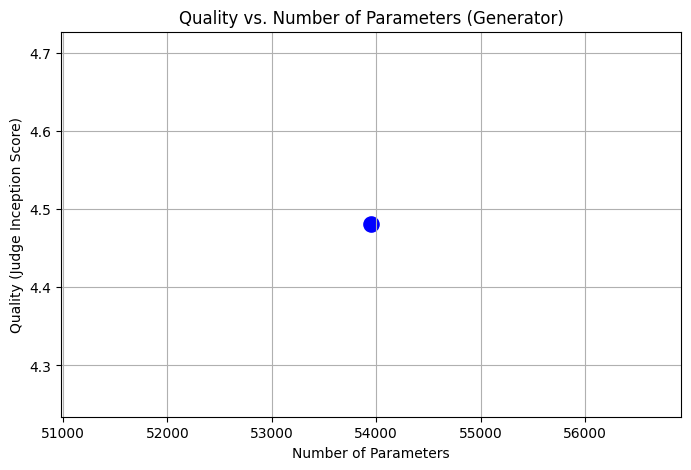

In [69]:
# quality vs number of parameters
def count_params(model):
    return sum(p.numel() for p in model.parameters())

G_params = count_params(gen)
D_params = count_params(disc)

print("Generator Parameters:", G_params)
print("Discriminator Parameters:", D_params)

qualities = [judge_is_score]
params = [G_params]

plt.figure(figsize=(8,5))
plt.scatter(params, qualities, color='blue', s=120)
plt.title("Quality vs. Number of Parameters (Generator)")
plt.xlabel("Number of Parameters")
plt.ylabel("Quality (Judge Inception Score)")
plt.grid(True)
plt.show()

### Quality vs training time

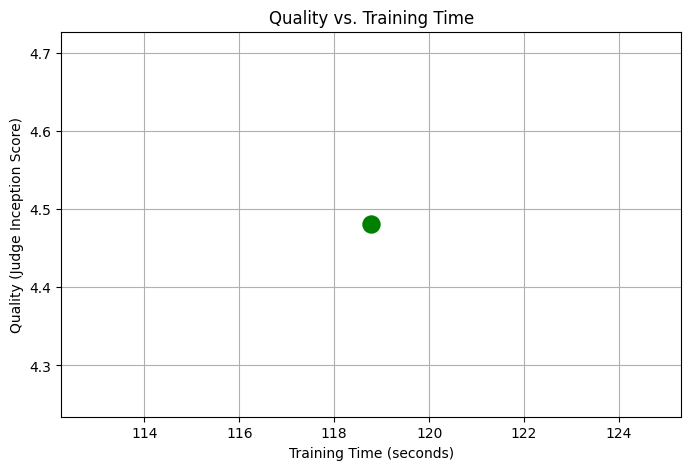

In [70]:
#quality vs training time
plt.figure(figsize=(8,5))
plt.scatter([total_train_time], [judge_is_score], color='green', s=150)
plt.title("Quality vs. Training Time")
plt.xlabel("Training Time (seconds)")
plt.ylabel("Quality (Judge Inception Score)")
plt.grid(True)
plt.show()

### Speed of Generation

Generation Speed: 654133.50 samples/sec


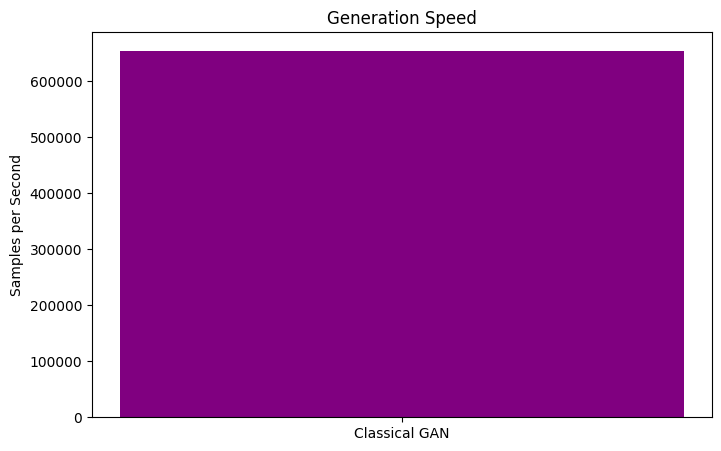

In [71]:
#speed of generation
start = time.time()
with torch.no_grad():
    z = torch.randn(5000, latent_dim).to(device)
    fake_imgs = gen(z)
end = time.time()

gen_time = end - start
speed = 5000 / gen_time

print(f"Generation Speed: {speed:.2f} samples/sec")

plt.figure(figsize=(8,5))
plt.bar(["Classical GAN"], [speed], color='purple')
plt.title("Generation Speed")
plt.ylabel("Samples per Second")
plt.show()